<a href="https://colab.research.google.com/github/erikrozi/acmlab/blob/reslayers/Copy_of_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in the Shared Google Drive
FOLDERNAME = 'Shared drives/Unsupervised'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/{}'.format(FOLDERNAME))

# !pwd
%cd /content/drive/$FOLDERNAME/
# %cp -vR * /content
# %cd /content
# !pwd
# !unzip imagery.zip -d imagery
# !unzip test_imagery.zip -d test_imagery
# %ls -lh

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/drive
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-16f4881d5b56>", line 16, in <module>
    get_ipython().magic('cd /content/drive/$FOLDERNAME/')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected


OSError: ignored

In [ ]:
 #!unzip imagery.zip -d imagery
 #!unzip test_imagery.zip -d test_imagery

# drive.flush_and_unmount()
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

import math

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: ignored

# Load Census Data

In [ ]:
# Loads data with zip and aveincome
tax_returns_data = pd.read_csv("16zpallnoagi.csv")
cleaned_tax_data = pd.DataFrame(tax_returns_data, columns = ["ZIPCODE", "N1", "A02650"])
cleaned_tax_data = cleaned_tax_data[(cleaned_tax_data['ZIPCODE'] <= 97000) & (cleaned_tax_data['ZIPCODE'] >= 90000)] #remove zipcodes not in california
cleaned_tax_data.columns = ['zip', 'N1', 'A02650']
cleaned_tax_data['aveincome'] = ((cleaned_tax_data['A02650'] / cleaned_tax_data['N1']))#.astype(np.int32)

In [ ]:
# Loads zips for Los Angeles
ziplation_data = pd.read_csv("ziplatlon.csv", sep = ";")
parsed_ziplation_data = ziplation_data[(ziplation_data['latitude'] <= 34.3) & (ziplation_data['latitude'] >= 33.5) & (ziplation_data['longitude'] >= -118.6) & (ziplation_data['longitude'] <= -117.6)]
parsed_ziplation_data = pd.merge(parsed_ziplation_data, cleaned_tax_data, how='left', on= 'zip')
parsed_ziplation_data = parsed_ziplation_data.dropna()

In [ ]:
import util as util
import webmercator as webmercator

In [ ]:
# creates image data and pulls latitude and longitude
z = 14
pos = np.empty([1980, 5])
for x in range(2794, 2839):
  for y in range(6528, 6572):
    curPos = (x - 2794) * (6572 - 6528) + (y - 6528)
    pos[curPos, 0] = x
    pos[curPos, 1] = y
    pos[curPos, 2] = webmercator.lat(y, z)
    pos[curPos, 3] = webmercator.lon(x, z)
    pos[curPos, 4] = util.getElevation(pos[curPos, 2], pos[curPos, 3])
image_pos_data = pd.DataFrame({'x': pos[:,0].astype(int), 'y': pos[:,1].astype(int), 'z': 14, 'latitude': pos[:,2], 'longitude': pos[:,3], 'elevation': pos[:,4]})
image_pos_data['img'] = "14_" + image_pos_data['x'].astype(str) + "_" + image_pos_data['y'].astype(str) + ".jpg"

Maps image to closest zip code

In [ ]:
def calc_distance(lat1, long1, lat2, long2):
  xdist = long1 - long2
  ydist = lat1 - lat2
  return math.sqrt(xdist**2 + ydist**2)

In [ ]:
np_ziplation = parsed_ziplation_data.to_numpy()
tile_zips = np.empty([image_pos_data.shape[0], 1])

np_ziplation.shape

#very inefficient lol
#for each image tile, loops through all the possible zipcodes, and chooses the one with the smallest distance
for i in range(image_pos_data.shape[0]):
  min_dist = 100000 #just made this an arbitrarily large number cuz iwas lazy
  for j in range(np_ziplation.shape[0]):
    zip_coords = np_ziplation[j][7].split(",") #splitting geopoint coords into latitude and longitude
    pt = image_pos_data['latitude'][i]
    cur_dist = calc_distance(pt, image_pos_data['longitude'][i], float(zip_coords[0]), float(zip_coords[1]))
    if cur_dist < min_dist:
      min_dist = cur_dist
      tile_zips[i] = np_ziplation[j][0]
image_pos_data['zipcode'] = tile_zips.astype(np.int32)

NameError: ignored

In [ ]:
# Gets rid of ocean tiles
image_pos_data = image_pos_data[~(image_pos_data['elevation'] == 0)]

In [ ]:
image_income_data = pd.DataFrame(image_pos_data, columns = ['img', 'zipcode'])
image_income_data.columns = ['img', 'zip']
image_income_data = pd.merge(image_income_data, cleaned_tax_data, how='left', on='zip')
image_income_data

In [ ]:
# Remove the unnecessary columns beside image url & average income
image_income_data = image_income_data[['img', 'aveincome', 'zip']]
image_income_data

In [ ]:
image_income_data.to_csv('image_income_data.csv')

# Load the imagery data


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TileImageryDataset(Dataset):
  """Tile imagery dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    # Load into tensors
    self.annotations = pd.read_csv(csv_file)
    #self.annotations.iloc[:,2] = self.annotations.iloc[:, 2].astype('float32')
    self.root_dir = root_dir
    self.transform = transform

    # Perform data augmentation

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    image = Image.open(self.root_dir +  self.annotations.iloc[index,1])
    y_label = torch.tensor(self.annotations.iloc[index, 2])

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 64

transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.Grayscale(),
    transforms.RandomRotation(degrees = 90),
    transforms.ToTensor(),      
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                
])

dataset = TileImageryDataset(csv_file = 'image_income_data.csv', root_dir = 'imagery/', transform = transformations)
#test_dataset =  TileImageryDataset(csv_file = 'image_income_data.csv', root_dir = 'imagery/', transform = transforms.ToTensor())
#dataset_indices = list(range(len(dataset)))
#train_indices, test_indices = dataset_indices[:1200], dataset_indices[1200:]
#train_indices, test_indices = dataset_indices[:32], dataset_indices[32:]

#train_sampler = SubsetRandomSampler(train_indices)
#test_sampler = SubsetRandomSampler(test_indices)

#trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
#testloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 257])

trainloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)
testloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle=False)



In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)


torch.Size([32, 3, 256, 256])
torch.Size([32])


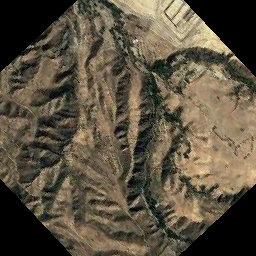

In [ ]:
i = 0
image, label = dataset[i]
image = np.moveaxis(image.numpy(), 0, -1)
image = (image * 255).astype(np.uint8)
display(Image.fromarray(image).convert("RGB"))

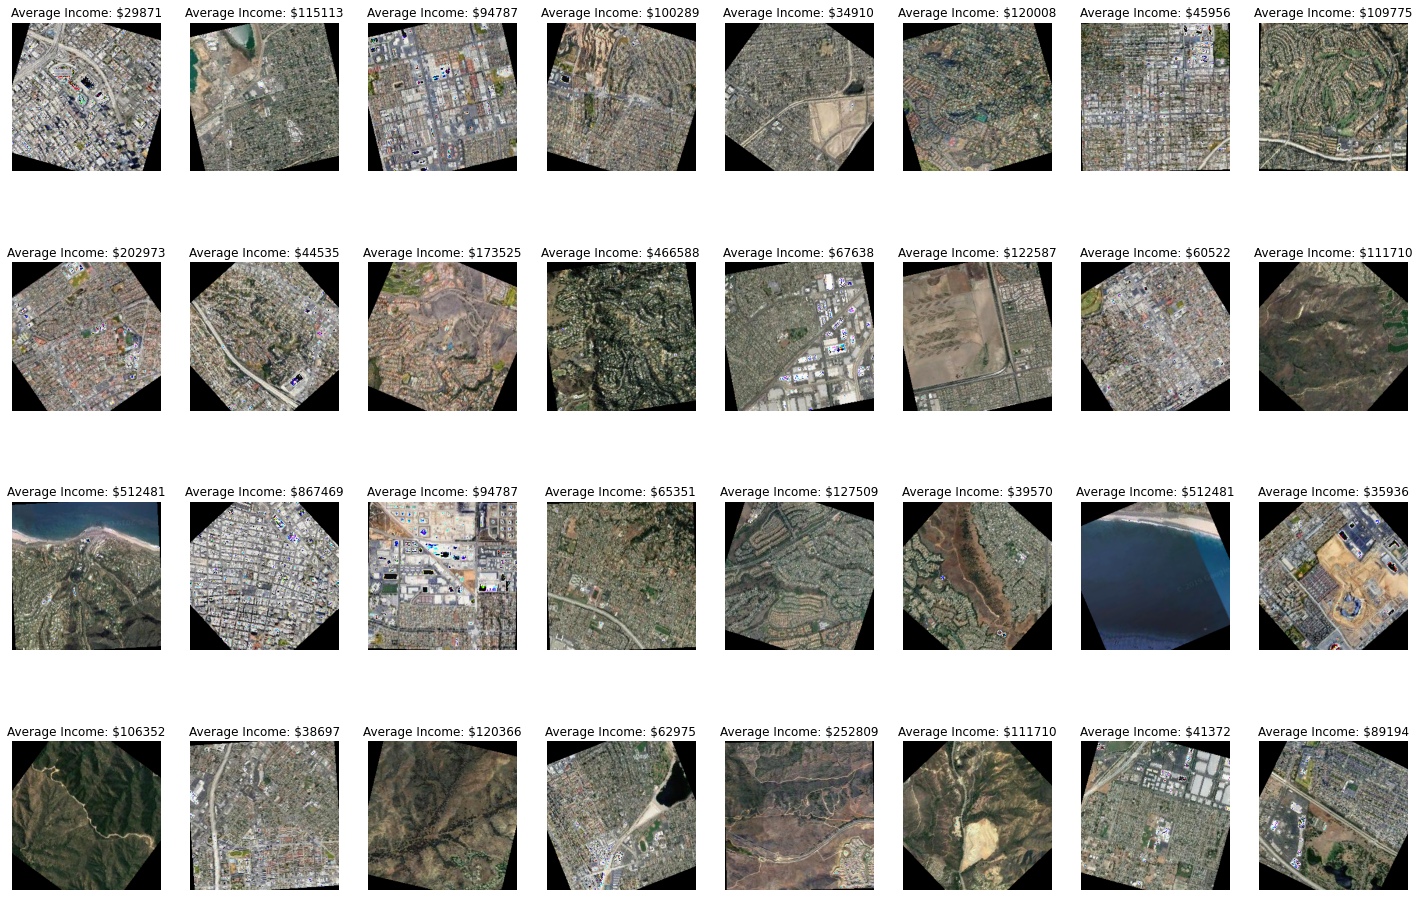

In [ ]:
figure = plt.figure(figsize=(25, 10))
plt.subplots_adjust(top=1.4)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title('Average Income: ${}'.format((int)(labels[idx]*1000)))
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNet, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = torch.nn.Dropout(p=0.5)

    self.conv1 = nn.Conv2d(3, 120, 7, padding=3, stride=2)
    self.bn1 = nn.BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.res1 = nn.Sequential(conv_block(120, 120), conv_block(120, 120))
    self.conv2 = nn.Conv2d(120, 120, 7, padding=3)
    self.bn2 = nn.BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.res2 = nn.Sequential(conv_block(120, 120), conv_block(120, 120))
    self.conv3 = nn.Conv2d(120, 120, 7, padding=3, stride=2)
    self.conv4 = nn.Conv2d(120, 120, 7, padding=3)
    self.conv5 = nn.Conv2d(120, 120, 7, padding=3,stride=2)
    self.conv6 = nn.Conv2d(120, 120, 5, padding=2)
    self.conv7 = nn.Conv2d(120, 120, 5, padding=2, stride=2)
    self.conv8 = nn.Conv2d(120, 120, 5, padding=2)
    self.conv9 = nn.Conv2d(120, 120, 5, padding=2, stride=2)
    self.conv10 = nn.Conv2d(120, 120, 5, padding=2)
    self.conv11 = nn.Conv2d(120, 120, 5, padding=2, stride=2)
    self.conv12 = nn.Conv2d(120, 120, 5, padding=2)

    # output of x.shape prior to calling fc1
    self.fc1 = nn.Linear(120*1*1, 120)
    self.fc2 = nn.Linear(120, 120)
    self.fc3 = nn.Linear(120, 1)

  def forward(self, x):
    x = self.bn1(self.conv1(x))

    x = self.res1(x)+x
    x = F.relu(x)
    #x = F.relu(self.conv1(x))
    x = self.dropout(x);
    x = F.relu(self.conv2(x))
    x = self.res2(x)+x
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    x = F.relu(self.conv8(x))
    x = F.relu(self.conv9(x))
    x = F.relu(self.conv10(x))
    x = F.relu(self.conv11(x))
    x = F.relu(self.conv12(x))

    #print(x.shape)
    x = x.view(-1, 120*1*1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    return x

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F



# class ConvolutionalNeuralNet(nn.Module):
#   def __init__(self):
#             super(ConvolutionalNeuralNet, self).__init__()
#             self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#             self.dropout = torch.nn.Dropout(p=0.5)
#             self.layer1 = nn.Sequential()
#             self.layer1.add_module("Conv1", nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer1.add_module("BN1", nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer1.add_module("Relu1", nn.ReLU(inplace=True))

#             self.layer2 = nn.Sequential()
#             self.layer2.add_module("Conv2", nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer2.add_module("BN2", nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer2.add_module("Relu2", nn.ReLU(inplace=True))

#             self.layer3 = nn.Sequential()
#             self.layer3.add_module("Conv3", nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer3.add_module("BN3", nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer3.add_module("Relu#", nn.ReLU(inplace=True))

#             self.layer4 = nn.Sequential()
#             self.layer4.add_module("Conv4", nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer4.add_module("BN4", nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer4.add_module("Relu4", nn.ReLU(inplace=True))

#             self.layer5 = nn.Sequential()
#             self.layer5.add_module("Conv5", nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer5.add_module("BN5", nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer5.add_module("Relu5", nn.ReLU(inplace=True))

#             self.layer6 = nn.Sequential()
#             self.layer6.add_module("Conv6", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer6.add_module("BN6", nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer6.add_module("Relu6", nn.ReLU(inplace=True))

#             self.layer7 = nn.Sequential()
#             self.layer7.add_module("Conv7", nn.Conv2d(512, 512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer7.add_module("BN7", nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer7.add_module("Relu7", nn.ReLU(inplace=True))

#             self.layer8 = nn.Sequential()
#             self.layer8.add_module("Conv8", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
#             self.layer8.add_module("BN8", nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#             self.layer8.add_module("Relu8", nn.ReLU(inplace=True))

#             self.fc1 = nn.Linear(120*1*1, 120, bias=True)
#             self.fc2 = nn.Linear(120, 120, bias=True)
#             self.fc3 = nn.Linear(120, 1, bias=True)

#   def forward(self, x):

#         x = self.pool(self.layer1(x))
#         print(x.shape)
#         x = self.pool(self.layer2(x))
#         x = self.pool(self.layer3(x))
#         x = self.pool(self.layer4(x))
#         x = self.pool(self.layer5(x))
#         x = self.pool(self.layer6(x))
#         x = self.pool(self.layer7(x))
#         x = self.pool(self.layer8(x))
#         print(x.shape)
#         x = x.view(-1, 120*1*1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x) 
        
#         return x

In [ ]:
writer = SummaryWriter()

In [ ]:
cnn_model = ConvolutionalNeuralNet().to(device=device)
cnn_model.train()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.0001) 
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(cnn_model.parameters(), lr = 0.001, momentum=0.9)
CLAMP = 200

epoch_losses = []

for epoch in range(100):
  epoch_loss = 0
  for batch_idx, (images, labels) in enumerate(trainloader):
    # Load the images and labels on the GPU
    images = images.to(device=device)
    #labels = labels.to(device=device, dtype=torch.float32)
    labels = labels.to(device=device)
    
    optimizer.zero_grad()                 # resets the information from last time
    pred_labels = cnn_model(images).squeeze()       # calculates the predictions
    #loss = criterion(pred_labels, labels)
    loss = criterion(pred_labels, torch.clamp(labels, 0, CLAMP).to(dtype=torch.float32)) # calculates the loss
    loss.backward()                       # gradient descent, part 1
    torch.nn.utils.clip_grad_norm(cnn_model.parameters(), 50) 
    optimizer.step()                      # gradient descent, part 2

    epoch_loss += loss.item() / labels.shape[0]
    if batch_idx % 10 == 0:
      print(f"Epoch {epoch}, batch {batch_idx}: {loss}")
  epoch_losses.append(epoch_loss)
  writer.add_scalar('Loss/train', epoch_loss, epoch)
  print(f"Epoch {epoch}: {epoch_loss}")

torch.Size([32, 64, 128, 128])


RuntimeError: ignored

In [ ]:
d%tensorboard --logdir runs

SyntaxError: ignored

In [ ]:
correct = 0
total = 0
loss = nn.L1Loss()
output = 0;
with torch.no_grad():
  for images, labels in testloader:
    outputs = cnn_model(images.to(device=device)).squeeze()  
    predicted = outputs.data.cpu().squeeze()  
    total += labels.size(0) 
    output = loss(predicted, labels)
# print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')
print(f'Accuracy of the network on the {total} test images: {output}')

Accuracy of the network on the 257 test images: 51.51583752169711


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:93: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


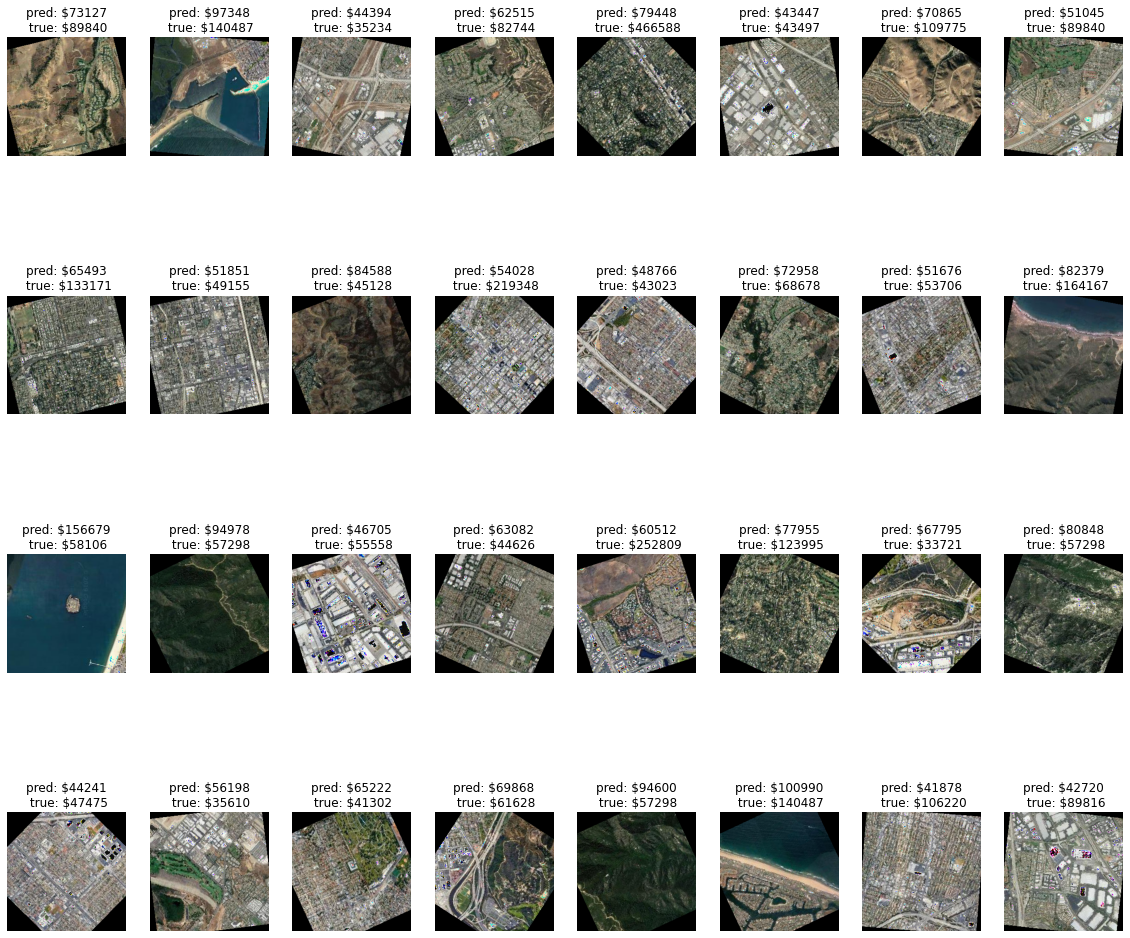

In [ ]:
images, labels = next(iter(testloader))
cnn_model.eval()
outputs = cnn_model(images.to(device=device))
predicted = outputs.data.cpu().numpy().squeeze()

figure = plt.figure(figsize=(20, 10))
plt.subplots_adjust(top=1.5)
num_rows = 4
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title(f"pred: ${(int)(predicted[idx] * 1000)}\n true: ${(int)(labels[idx] * 1000)}")
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)